## Running NUTS using a custom JVP 

In [1]:
import numpyro
from jax import grad, vmap
import jax.numpy as jnp 
print("version ",numpyro.__version__, "should be larger than 0.5") 

version  0.5.0 should be larger than 0.5


JVP $f(x,A)=A \sin{x}$

In [3]:
from jax import custom_jvp
@custom_jvp
def f(x, A):
    return A*jnp.sin(x)

@f.defjvp
def f_jvp(primals, tangents):
    x, A = primals
    ux, uA = tangents
    dfdx=A * jnp.cos(x)
    dfdA=jnp.sin(x)
    primal_out = f(x, A)
    tangent_out = dfdx * ux  + dfdA * uA
    return primal_out, tangent_out

In [4]:
fv=vmap(f,(0,None),0)

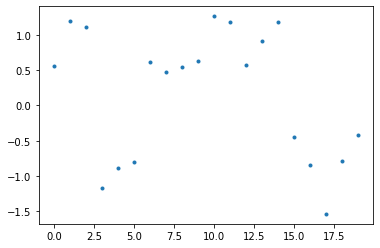

In [9]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(32)
sigin=0.3
N=20
x=np.sort(np.random.rand(N))*4*np.pi
data=fv(x,1.0)+np.random.normal(0,sigin,size=N)
plt.plot(data,".")
plt.show()

In [6]:
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist

def model(x,y):
    sigma = numpyro.sample('sigma', dist.Exponential(1.))
    x0 = numpyro.sample('x0', dist.Uniform(-1.,1.))
    A = numpyro.sample('A', dist.Exponential(1.))
    mu=f(x-x0,A)
    numpyro.sample('y', dist.Normal(mu, sigma), obs=y)

In [7]:
from jax import random
from numpyro.infer import MCMC, NUTS

# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 1000, 2000
kernel = NUTS(model,forward_mode_differentiation=True)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, x=x, y=data)
mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [00:05<00:00, 552.02it/s, 3 steps of size 6.40e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         A      1.13      0.11      1.13      0.96      1.31   1404.99      1.00
     sigma      0.34      0.06      0.33      0.24      0.44   1100.92      1.00
        x0      0.09      0.11      0.10     -0.07      0.28   1143.48      1.00

Number of divergences: 0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f60ef3418d0>,
      dtype=object)

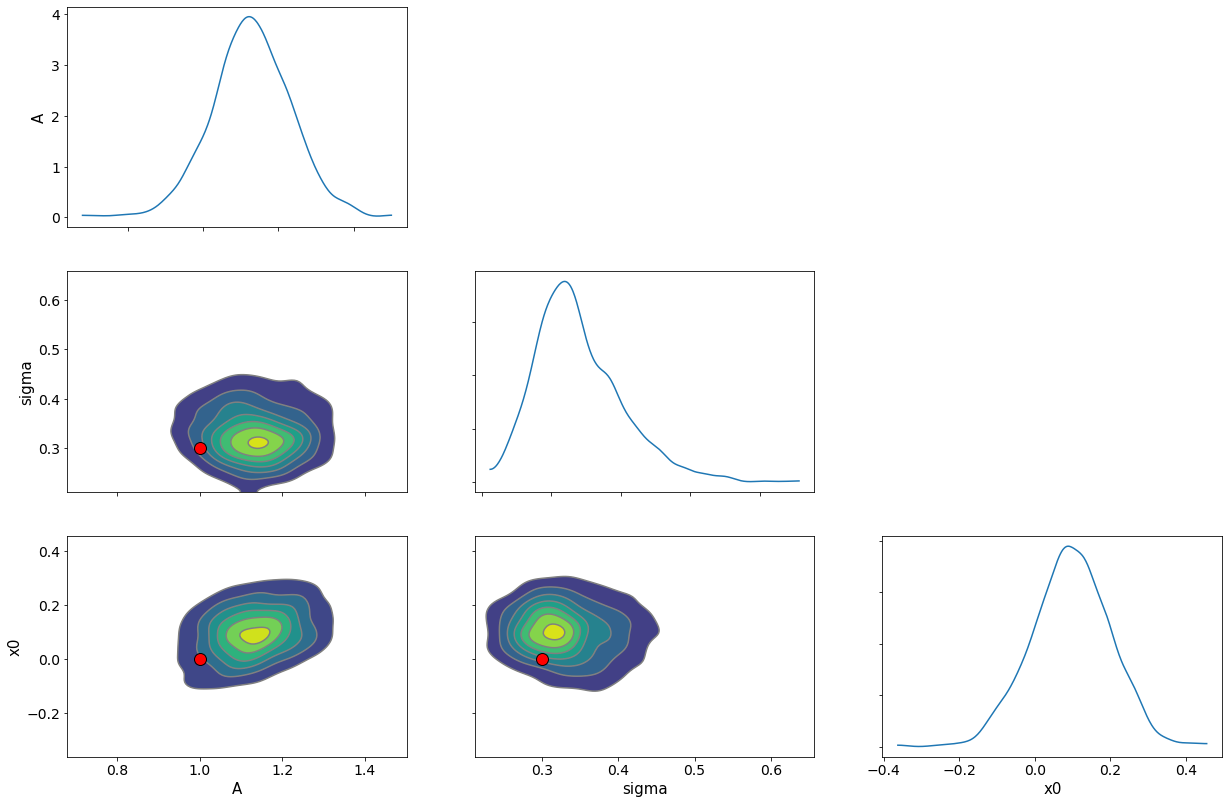

In [8]:
import arviz
refs={};refs["A"]=1.0;refs["sigma"]=sigin;refs["x0"]=0.0
arviz.plot_pair(arviz.from_numpyro(mcmc),kind='kde',
    divergences=False,marginals=True,reference_values=refs,
    reference_values_kwargs={'color':"red", "marker":"o", "markersize":12}) 

In [10]:
posterior_A = mcmc.get_samples()['A']
posterior_sigma = mcmc.get_samples()['sigma']
posterior_x0 = mcmc.get_samples()['x0']

from numpyro.infer import Predictive
pred = Predictive(model,{'A':posterior_A,'sigma':posterior_sigma,'x0':posterior_x0}\
                  ,return_sites=["y"])
x_ = jnp.linspace(0,4*jnp.pi,1000)
predictions = pred(rng_key_,x=x_,y=None)

In [11]:
from numpyro.diagnostics import hpdi
mean_muy = jnp.mean(predictions["y"], axis=0)
hpdi_muy = hpdi(predictions["y"], 0.9)

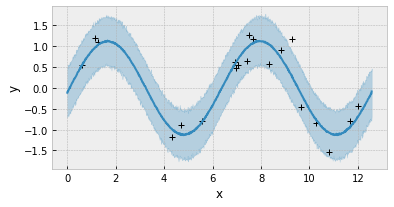

In [13]:
import seaborn as sns
plt.style.use('bmh')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
ax.plot(x,data,"+",color="black")
ax.plot(x_,mean_muy,color="C0")
ax.fill_between(x_, hpdi_muy[0], hpdi_muy[1], alpha=0.3, interpolate=True,color="C0")
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("jvpnuts.pdf")